In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import losses

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

from utils.data_loader import create_dataset
from utils.model_loss import TverskyBCEPerSequence
from utils.model_inference_plots import *

In [2]:
df = pd.read_parquet('data/final_model_data_all_labeled_test.parquet')
event_df = pd.read_csv('data/event_data_all_perp_80_avg.csv')

In [3]:
X_test = df[['Bx', 'By', 'Bz', 'Bx_lag_1', 'Bx_lag_2', 'By_lag_1',
             'By_lag_2', 'Bz_lag_1', 'Bz_lag_2', 'Bx_conditional_vol',
             'By_conditional_vol', 'Bz_conditional_vol', 'Bx_rolling_stdev',
             'By_rolling_stdev', 'Bz_rolling_stdev']].values

y_test = df['Event_label_80'].values

In [4]:
test_size = len(X_test)
n_features = X_test.shape[1]

In [ ]:
batch_size = 256
n_timesteps = 500
stride = 40

test_idx = (0, len(df))

test_dataset = create_dataset(X, y, n_timesteps, batch_size, stride, test_idx[0], test_idx[1])

In [7]:
steps_test_epoch = int(np.ceil((test_size - n_timesteps) / (stride * batch_size)))

In [9]:
model = keras.models.load_model(
    "models/mosrl_80_all_model.keras",
    custom_objects={"tversky_bce_per_sequence": TverskyBCEPerSequence}
)

In [ ]:
# keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_dtype= False,
#     show_layer_names=False,
#     rankdir="TD",
#     expand_nested=False,
#     dpi=200,
#     show_layer_activations=False,
#     show_trainable=False,
# )

In [12]:
y_pred_probas = np.load("models/mosrl_80_all_pred_probas.npy")

In [ ]:
# Create a dataframe to get metrics at different probability thresholds
df_threshold = pd.DataFrame()

for i, th in enumerate(np.arange(0.0, 1.00, 0.01)):
    test_labels_l =  (y_pred_probas >= th).astype(int)
    df_threshold.loc[i, 'threshold'] = np.round(th, 2)
    df_threshold.loc[i, 'accuarcy'] = np.round(accuracy_score(y_test, test_labels_l), 3)
    df_threshold.loc[i, 'precision'] = np.round(precision_score(y_test, test_labels_l, zero_division=0.0), 3)
    df_threshold.loc[i, 'recall'] = np.round(recall_score(y_test, test_labels_l, zero_division=0.0), 3)
    df_threshold.loc[i, 'f1_score'] = np.round(f1_score(y_test, test_labels_l), 3)

In [ ]:
# Plots the precision and recall curves and identifies the intersections
plot_precision_recall(df_threshold, mode='intersection')

In [ ]:
# Plots the precision and recall curves and identifies the optimal based on max f1-score
plot_precision_recall(df_threshold, mode='optimal')

In [ ]:
threshold = 0.58
y_pred = (y_pred_probas >= threshold).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87   7474465
           1       0.73      0.85      0.79   4009036

    accuracy                           0.84  11483501
   macro avg       0.82      0.84      0.83  11483501
weighted avg       0.85      0.84      0.84  11483501



In [14]:
df['Event_pred_probas'] = y_pred_probas
df['Event_pred'] = y_pred

In [15]:
df['Time_diff'] = df['Epoch_time'].diff().fillna(0)

In [ ]:
# Identify valid events based on change in class and ensures correct time boundaries
df['Class_change'] = (
    (df['Event_class'] != df['Event_class'].shift()) |
    (df['Time_diff'] > 300) |
    (df['Time_diff'] < 0)
).cumsum()

valid_events = df[df['Event_label_80'] == 1]
event_groups = valid_events.groupby(['Class_change', 'Satellite', 'Event_class'])

In [17]:
ratios_by_class = defaultdict(list)
hist_data = []

for (key, group) in event_groups:
    class_change, satellite, cls = key
    satellite = group['Satellite'].iloc[0]

    true_label = group['Event_label_80'].values
    pred_label = group['Event_pred'].values

    N_j = np.sum(true_label)
    Nt_j = np.sum(pred_label == 1)

    ratio = Nt_j / N_j
    ratios_by_class[cls].append(ratio)
    hist_data.append({'Class': cls, 'Satellite': satellite, 'Ratio': ratio})

df_hist = pd.DataFrame(hist_data)

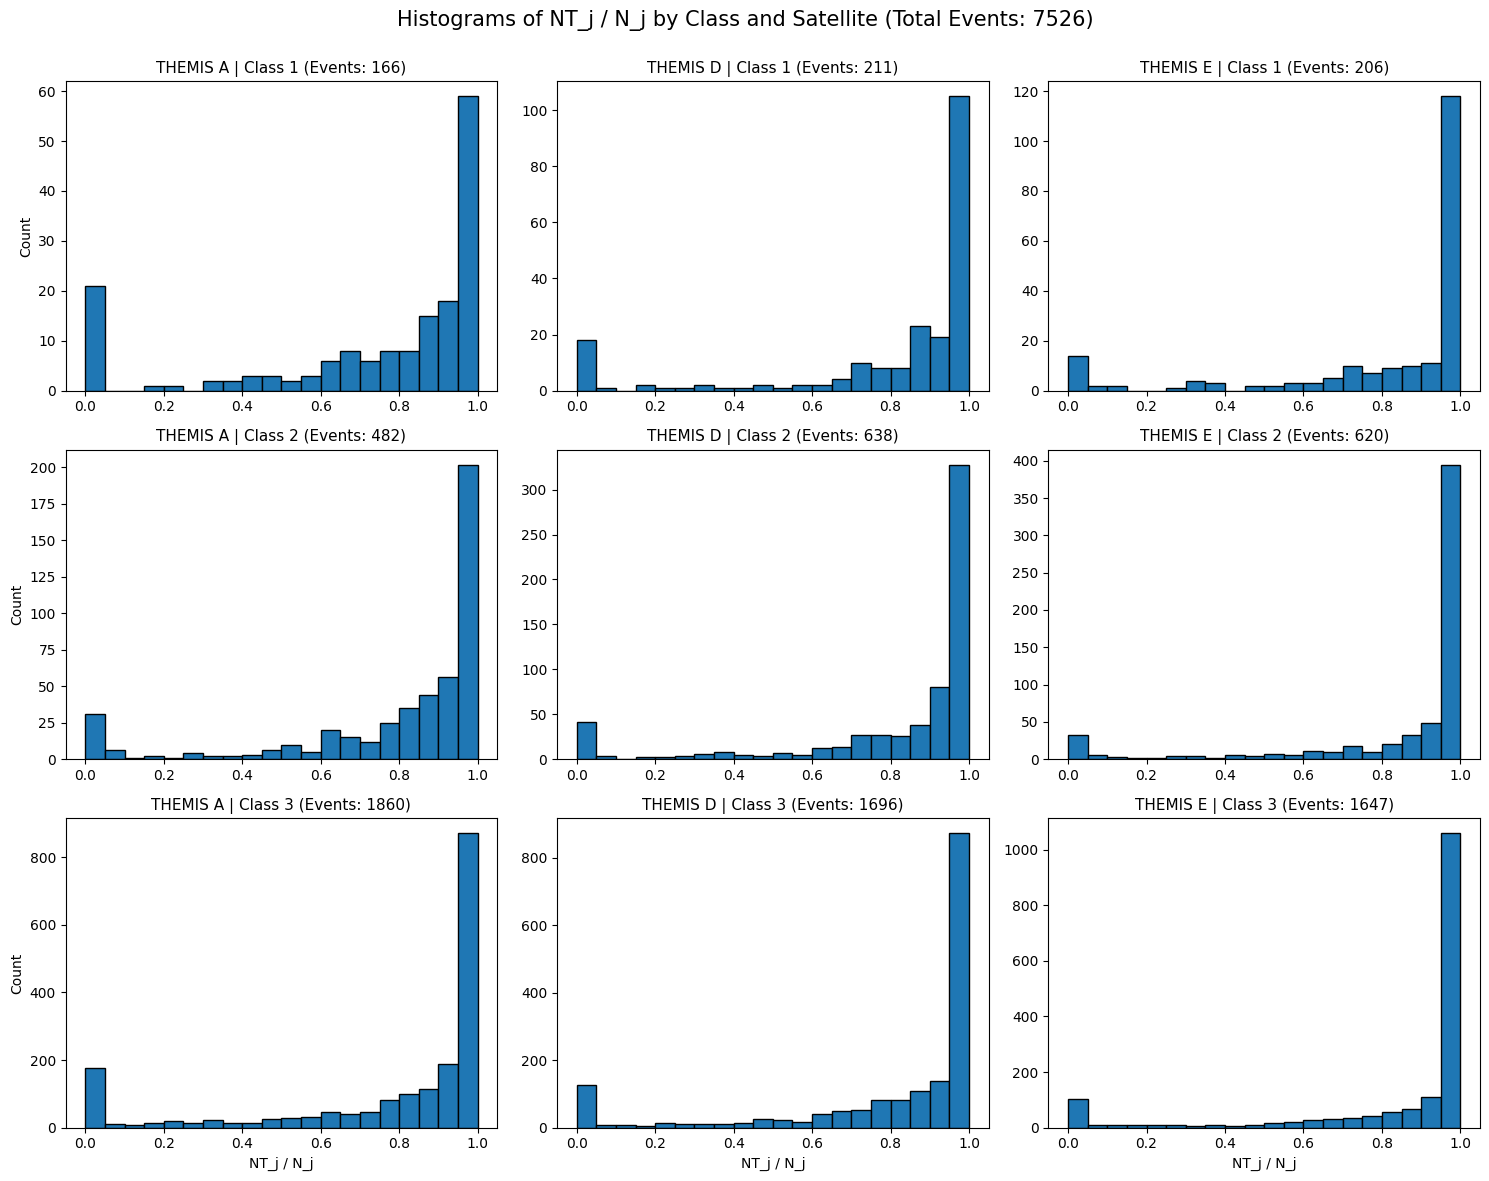

In [ ]:
# Plots the histograms of captured event timesteps in each event interval
# separated by event class and satellite
satellites = sorted(df_hist["Satellite"].unique())
classes = sorted(df_hist["Class"].unique())

n_rows = len(classes)
n_cols = len(satellites)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

if n_rows == 1:
    axes = [axes]
elif n_cols == 1:
    axes = [[ax] for ax in axes]

for i, cls in enumerate(classes):
    for j, sat in enumerate(satellites):
        ax = axes[i][j]
        subset = df_hist[(df_hist["Class"] == cls) & (df_hist["Satellite"] == sat)]
        ax.hist(subset["Ratio"], bins=20, edgecolor='black')

        ax.set_title(f"{sat} | Class {cls} (Events: {len(subset)})", fontsize=11)

        if i == n_rows - 1:
            ax.set_xlabel("NT_j / N_j")
        if j == 0:
            ax.set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle(f"Histograms of NT_j / N_j by Class and Satellite (Total Events: {len(df_hist)})", fontsize=15)
plt.show()

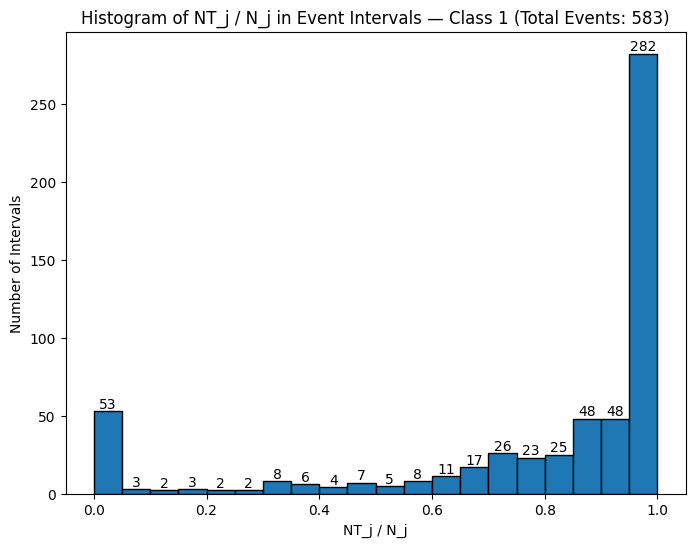

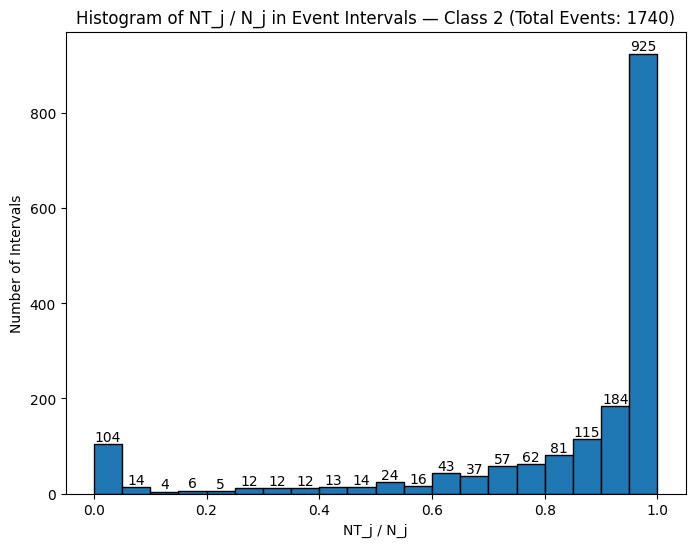

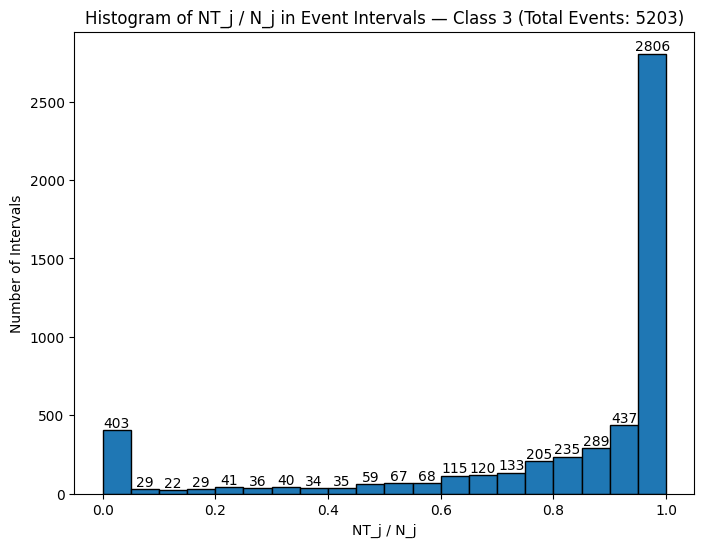

In [ ]:
# Histogram of the captured timesteps and true timesteps in each event interval separated by class
for cls, ratios in sorted(ratios_by_class.items()):
    plt.figure(figsize=(8, 6))
    counts, bins, patches = plt.hist(ratios, edgecolor='black', bins=20)
    for count, bin_edge in zip(counts, bins[:-1]):
        if count > 0:
            plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)),
                     ha='center', va='bottom', fontsize=10)

    plt.xlabel('NT_j / N_j')
    plt.ylabel('Number of Intervals')
    plt.title(f'Histogram of NT_j / N_j in Event Intervals — Class {cls} (Total Events: {len(ratios)})')
    plt.show()

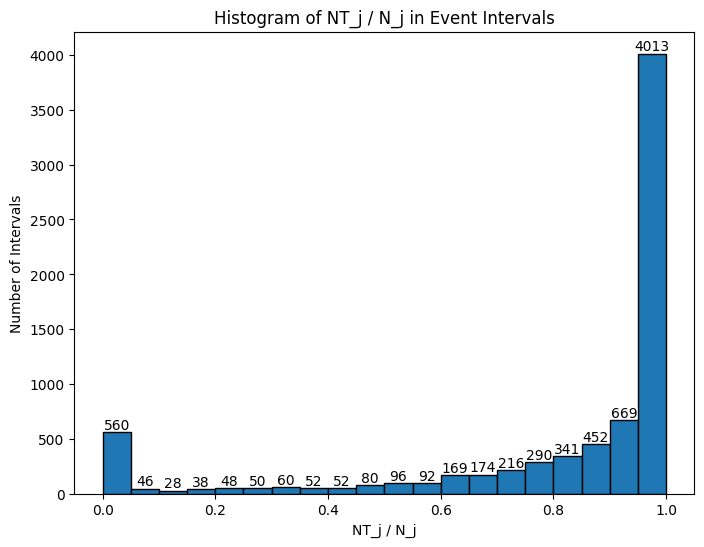

In [20]:
plt.figure(figsize=(8, 6))
counts, bins, patches = plt.hist(sum(ratios_by_class.values(), []), bins=20, edgecolor='k')
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)),
             ha='center', va='bottom', fontsize=10)

plt.xlabel("NT_j / N_j")
plt.ylabel("Number of Intervals")
plt.title("Histogram of NT_j / N_j in Event Intervals")
plt.show()

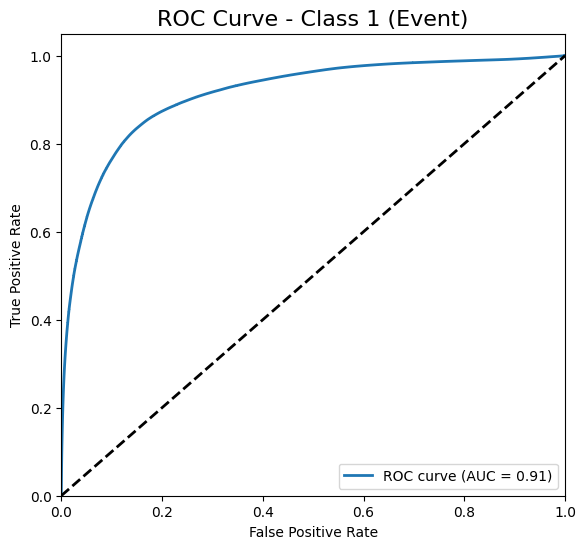

In [21]:
plot_positive_class_roc(y_test, y_pred_probas, dpi=100)

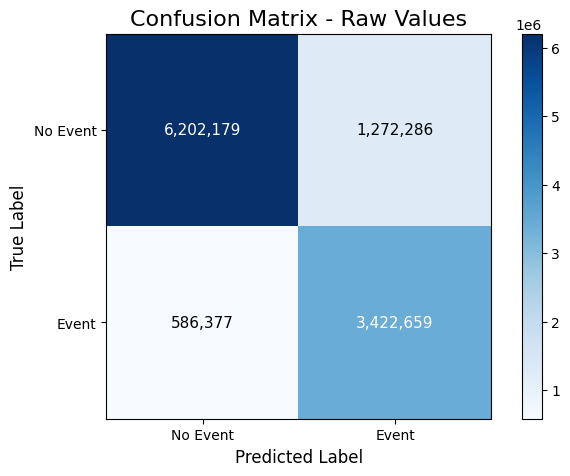

In [22]:
plot_raw_confusion_matrix(y_test, y_pred, dpi=100)

In [ ]:
# Extracts the missed and captured event intervals
# Creates false and non event intervals if the difference in timestep > 300 (5 minutes)

low_ratio_sequences = event_analysis(event_groups, ratio_threshold=0.05, side="lower")
high_ratio_sequences = event_analysis(event_groups, ratio_threshold=0.9, side="upper")

false_events = df.query("Event_label_80 == 0 and Event_pred == 1")
false_sequences = false_events.groupby((false_events['Epoch_time'].diff() > 300).cumsum()).apply(lambda x: list(x.index)).values

non_events = df.query("Event_label_80 == 0 and Event_pred == 0")
non_event_sequences = non_events.groupby((non_events['Epoch_time'].diff() > 300).cumsum()).apply(lambda x: list(x.index)).values

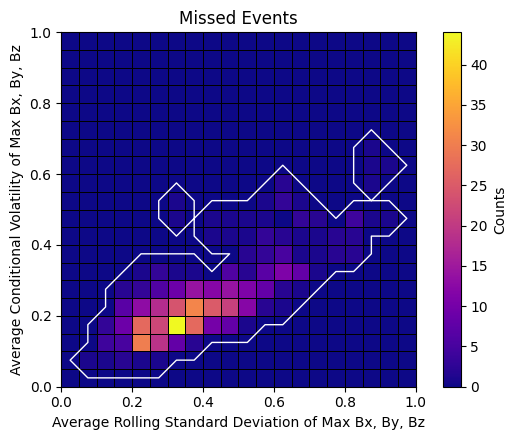

In [ ]:
# 2D histograms to visualize the interactions between the features with last bin removed
plot_vol_stdev_2d_avg_histogram(extract_max_features(low_ratio_sequences, df, True), event_type='Missed', thershold=0.95)

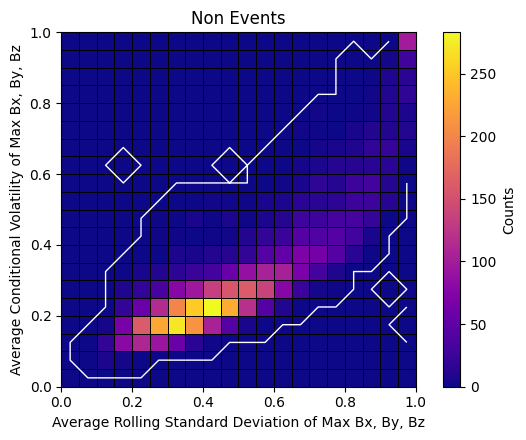

In [ ]:
plot_vol_stdev_2d_avg_histogram(extract_max_features(non_event_sequences, df, False), event_type='Non', thershold=0.95)

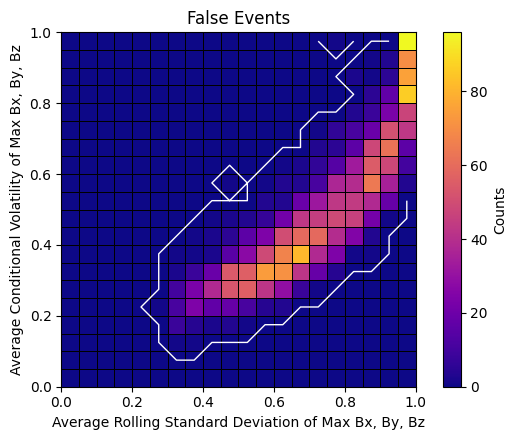

In [ ]:
plot_vol_stdev_2d_avg_histogram(extract_max_features(false_sequences, df, False), event_type='False', thershold=0.95)

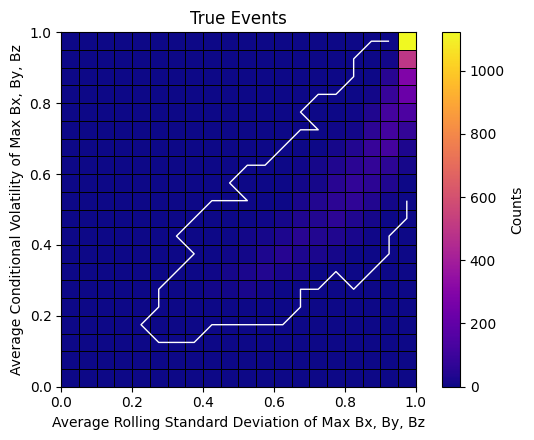

In [ ]:
plot_vol_stdev_2d_avg_histogram(extract_max_features(high_ratio_sequences, df, True), event_type='True', thershold=0.95)

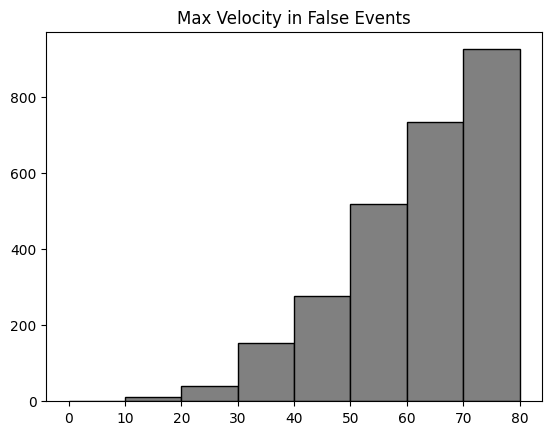

In [ ]:
# Historgram of the velocity during false events
bins = np.arange(0, 90, step=10)
plt.hist(extract_max_features(false_sequences, df, False)['velocity'], bins=bins, color='gray', edgecolor='black')
plt.title("Max Velocity in False Events")
plt.xticks(bins)
plt.show()

In [ ]:
# Filter to THEMIS A for plotting time series plots
df_satellite = df.query("Satellite == 'THEMIS A'").reset_index(drop=True)
event_df_satellite = event_df.query("satellite_name == 'THEMIS A'").reset_index(drop=True)

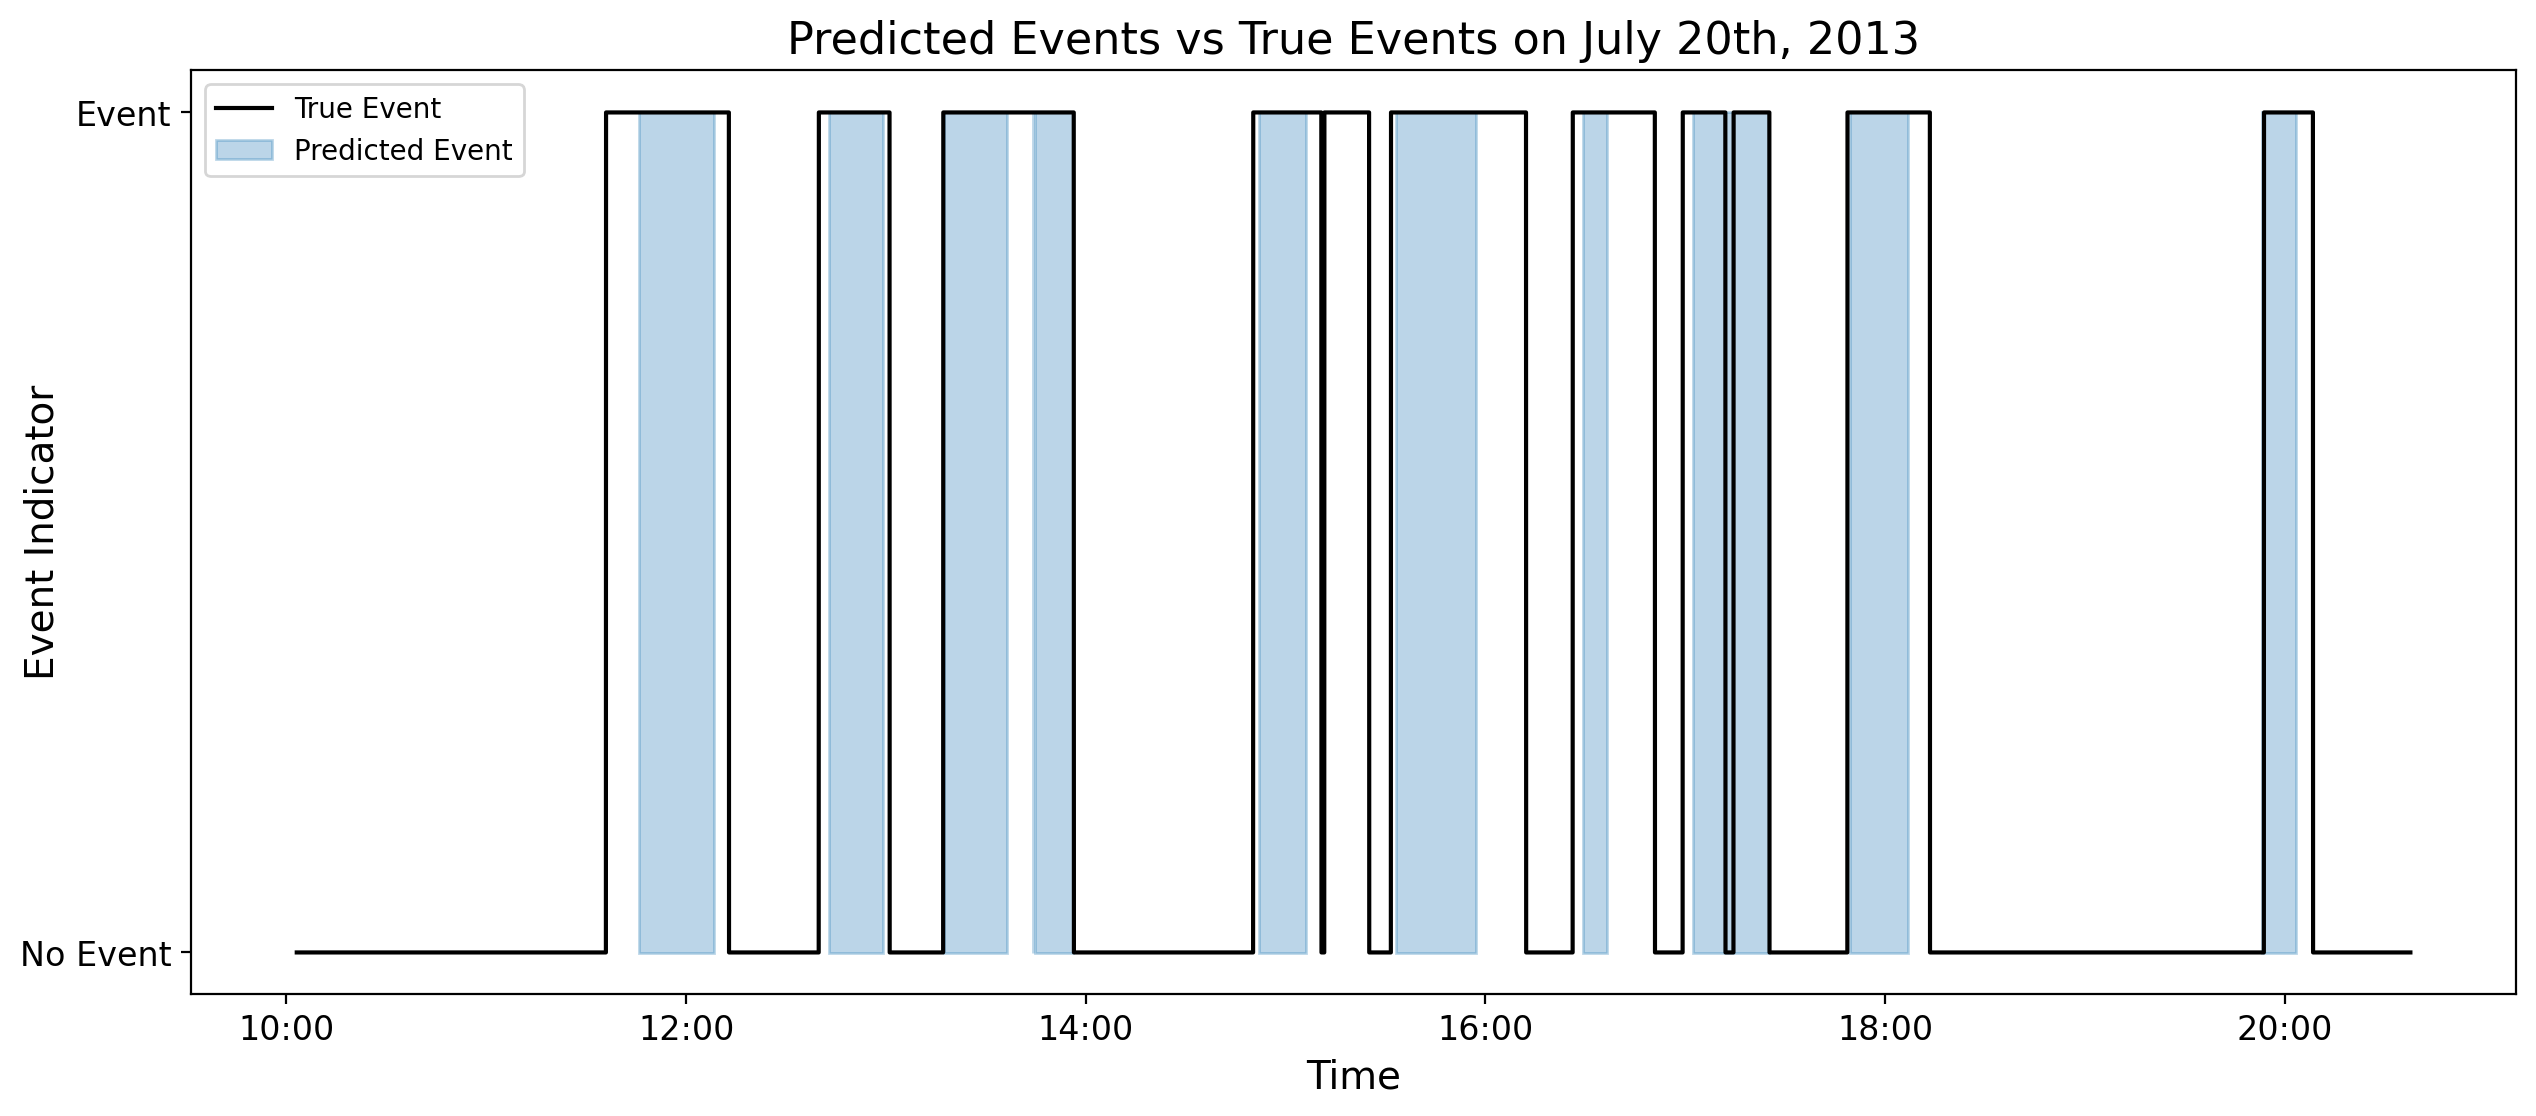

In [31]:
plot_true_vs_pred(df_satellite, event_df_satellite, start_idx=0, end_idx=12998, dpi=200)

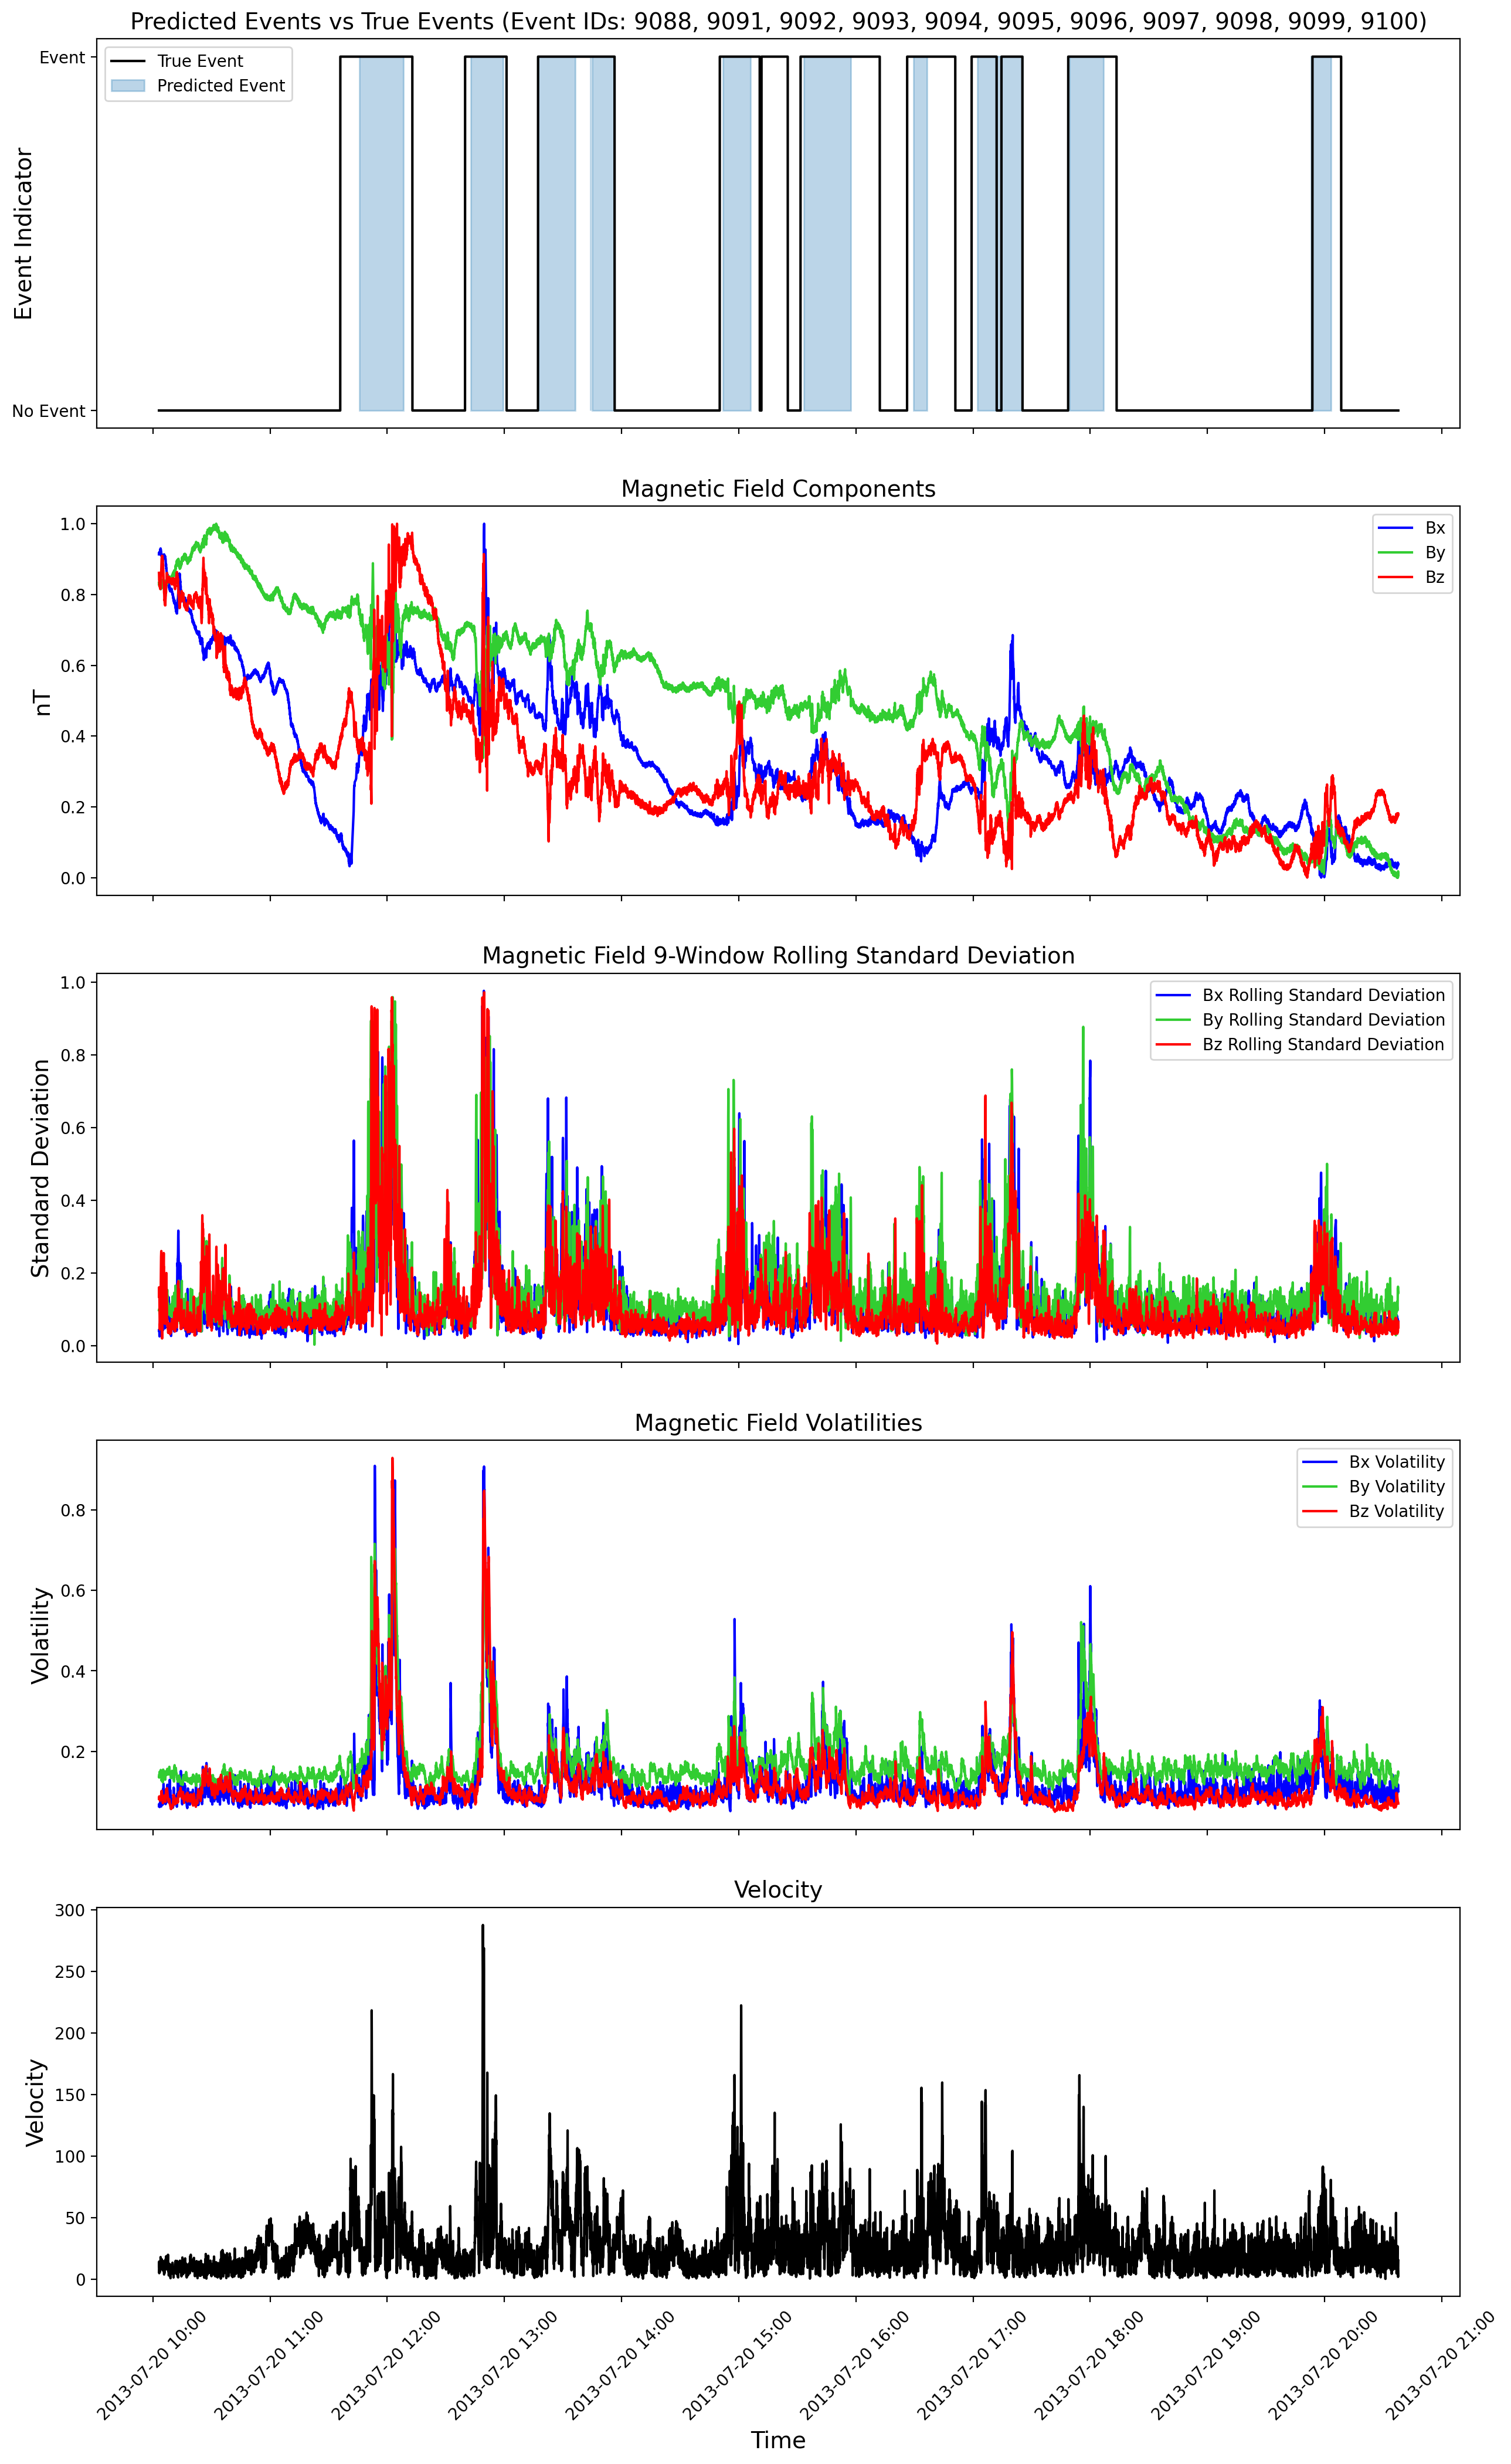

In [32]:
plot_true_vs_pred_all(df_satellite, event_df_satellite, start_idx=0, end_idx=12998, dpi=200)